## Installations

In [1]:
!pip install diffusers transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [4]:
#!unzip '/content/drive/MyDrive/Gautam QR/Images/train_dataset.zip'
!unzip '/content/drive/MyDrive/Gautam QR/Images/test_dataset2.zip'

Archive:  /content/drive/MyDrive/Gautam QR/Images/test_dataset2.zip
   creating: content/Test Dataset1/
   creating: content/Test Dataset1/.ipynb_checkpoints/
   creating: content/Test Dataset1/Blur/
  inflating: content/Test Dataset1/Blur/7.jpg  
  inflating: content/Test Dataset1/Blur/73.jpg  
  inflating: content/Test Dataset1/Blur/61.jpg  
  inflating: content/Test Dataset1/Blur/58.jpg  
  inflating: content/Test Dataset1/Blur/37.jpg  
  inflating: content/Test Dataset1/Blur/49.jpg  
  inflating: content/Test Dataset1/Blur/93.jpg  
  inflating: content/Test Dataset1/Blur/34.jpg  
  inflating: content/Test Dataset1/Blur/18.jpg  
  inflating: content/Test Dataset1/Blur/85.jpg  
  inflating: content/Test Dataset1/Blur/75.jpg  
  inflating: content/Test Dataset1/Blur/47.jpg  
  inflating: content/Test Dataset1/Blur/84.jpg  
  inflating: content/Test Dataset1/Blur/83.jpg  
  inflating: content/Test Dataset1/Blur/5.jpg  
  inflating: content/Test Dataset1/Blur/60.jpg  
  inflating: conte

In [ ]:
class BlurDataset(Dataset):
    def __init__(self, blur_dir, non_blur_dir, transform=None, train_transform = None):
        self.blur_dir = blur_dir
        self.non_blur_dir = non_blur_dir
        self.blur_images = sorted(os.listdir(blur_dir))
        self.non_blur_images = sorted(os.listdir(non_blur_dir))
        self.transform = transform
        self.train_transform = train_transform

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        blur_image = Image.open(os.path.join(self.blur_dir, self.blur_images[idx]))
        non_blur_image = Image.open(os.path.join(self.non_blur_dir, self.non_blur_images[idx]))

        if self.transform and self.train_transform:
            blur_image = self.train_transform(blur_image)
            non_blur_image = self.transform(non_blur_image)

        return blur_image, non_blur_image

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.4),
    # transforms.RandomVerticalFlip(p=0.4),
    # sharpness
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = BlurDataset('/content/content/Dataset/Blur', '/content/content/Dataset/Digital',
                      transform=transform, train_transform=train_transforms)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
len(dataset), len(dataloader)

(855, 214)

## Code

In [ ]:
import torch
from diffusers import DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer

# Load pretrained model components
model_id = "CompVis/stable-diffusion-v1-4"

# Initialize the text encoder and tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

# Initialize the VAE
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")

# Initialize the UNet
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Initialize the scheduler
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
vae.to(device)
text_encoder.to(device)

# Define training loop
num_epochs = 15

for epoch in range(num_epochs):
    for blur_images, non_blur_images in dataloader:
        optimizer.zero_grad()

        # Move images to GPU
        blur_images = blur_images.to(device)
        non_blur_images = non_blur_images.to(device)

        # Generate latents for the blurry images
        with torch.no_grad():
            blur_latents = vae.encode(blur_images).latent_dist.sample()
            blur_latents = blur_latents * 0.18215

        # Prepare timestep and encoder hidden states
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (blur_latents.shape[0],), device=device).long()

        # Generate text embeddings for conditioning
        input_text = ["a photo of a sharp image"] * blur_latents.shape[0]
        text_inputs = tokenizer(input_text, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
        text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

        # Forward pass through the UNet
        noise_pred = unet(blur_latents, timesteps, encoder_hidden_states=text_embeddings)["sample"]

        # Decode the noise prediction to pixel space
        reconstructed_latents = blur_latents - noise_pred  # Subtract the predicted noise from the input latents
        reconstructed_images = vae.decode(reconstructed_latents / 0.18215).sample


        # Calculate loss (mean squared error)
        loss = torch.nn.functional.mse_loss(reconstructed_images, non_blur_images)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1, Loss: 0.0907978042960167
Epoch 2, Loss: 0.08650548756122589
Epoch 3, Loss: 0.06933002173900604
Epoch 4, Loss: 0.03315005451440811
Epoch 5, Loss: 0.01816539466381073
Epoch 6, Loss: 0.005960175767540932
Epoch 7, Loss: 0.005625253077596426
Epoch 8, Loss: 0.00453078793361783
Epoch 9, Loss: 0.010374899953603745
Epoch 10, Loss: 0.0029689862858504057


KeyboardInterrupt: 

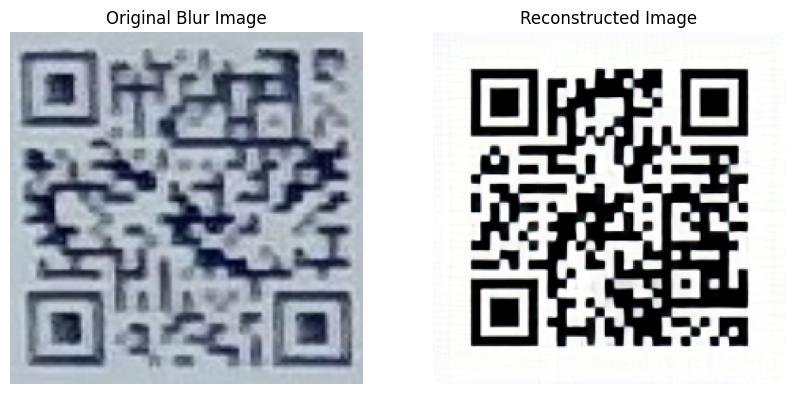

In [ ]:
import matplotlib.pyplot as plt
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)  # Add batch dimension

blur_image_path = '/content/content1/Dataset/Blur/53.jpg'
blur_image = preprocess_image(blur_image_path).to(device)

# Generate latents for the blurry image
with torch.no_grad():
    blur_latents = vae.encode(blur_image).latent_dist.sample()
    blur_latents = blur_latents * 0.18215

# Prepare text embeddings for conditioning
input_text = ["a photo of a sharp image"]
text_inputs = tokenizer(input_text, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

# Prepare timestep (use a specific timestep for inference, e.g., the median timestep)
timestep = torch.tensor([scheduler.num_train_timesteps // 2], device=device).long()

# Forward pass through the UNet
with torch.no_grad():
    noise_pred = unet(blur_latents, timestep, encoder_hidden_states=text_embeddings)["sample"]

# Decode the noise prediction to pixel space
with torch.no_grad():
    reconstructed_latents = blur_latents - noise_pred  # Subtract the predicted noise from the input latents
    reconstructed_images = vae.decode(reconstructed_latents / 0.18215).sample

# Convert the tensors to images
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).cpu().clamp(0, 1)
    return transforms.ToPILImage()(tensor)

reconstructed_image = tensor_to_image(reconstructed_images)
original_blur_image = tensor_to_image(blur_image)

# Display the original blur image and the reconstructed image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_blur_image)
axes[0].set_title('Original Blur Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

In [ ]:
unet.save_pretrained("/content/drive/MyDrive/Gautam QR/fine_tuned_model1")

## Inference

In [ ]:
!unzip '/content/drive/MyDrive/Gautam QR/Images/test_only1.zip'

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


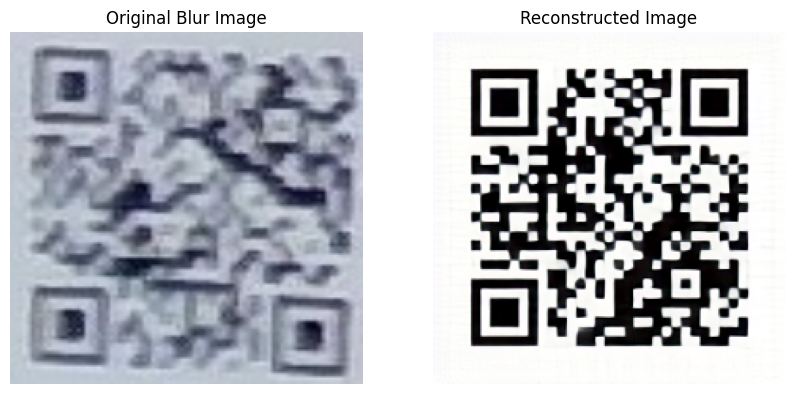

In [5]:
import torch
from diffusers import UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Load pretrained model components
model_id = "CompVis/stable-diffusion-v1-4"

# Initialize the text encoder and tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

# Initialize the VAE
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Initialize the UNet with the fine-tuned model
unet = UNet2DConditionModel.from_pretrained("/content/drive/MyDrive/Gautam QR/fine_tuned_model1")

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
vae.to(device)
text_encoder.to(device)

# Load and preprocess the blur image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)  # Add batch dimension

blur_image_path = '/content/content/Test Dataset1/Blur/31.jpg'
blur_image = preprocess_image(blur_image_path).to(device)

# Generate latents for the blurry image
with torch.no_grad():
    blur_latents = vae.encode(blur_image).latent_dist.sample()
    blur_latents = blur_latents * 0.18215

# Prepare text embeddings for conditioning
input_text = ["a photo of a sharp image"]
text_inputs = tokenizer(input_text, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

# Prepare timestep (use a specific timestep for inference, e.g., the median timestep)
timestep = torch.tensor([scheduler.num_train_timesteps // 2], device=device).long()

# Forward pass through the UNet
with torch.no_grad():
    noise_pred = unet(blur_latents, timestep, encoder_hidden_states=text_embeddings)["sample"]

# Decode the noise prediction to pixel space
with torch.no_grad():
    reconstructed_latents = blur_latents - noise_pred  # Subtract the predicted noise from the input latents
    reconstructed_images = vae.decode(reconstructed_latents / 0.18215).sample

# Convert the tensors to images
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).cpu().clamp(0, 1)
    return transforms.ToPILImage()(tensor)

reconstructed_image = tensor_to_image(reconstructed_images)
original_blur_image = tensor_to_image(blur_image)

# Display the original blur image and the reconstructed image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_blur_image)
axes[0].set_title('Original Blur Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

In [7]:
import torch
from diffusers import UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load pretrained model components
model_id = "CompVis/stable-diffusion-v1-4"

# Initialize the text encoder and tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

# Initialize the VAE
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Initialize the UNet with the fine-tuned model
unet = UNet2DConditionModel.from_pretrained("/content/drive/MyDrive/Gautam QR/fine_tuned_model1")

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
vae.to(device)
text_encoder.to(device)

# Load and preprocess the blur image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)  # Add batch dimension

for i in range(5,65,3):
    blur_image_path = f'/content/content/Test Dataset1/Blur/{i}.jpg'
    blur_image = preprocess_image(blur_image_path).to(device)

    # Generate latents for the blurry image
    with torch.no_grad():
        blur_latents = vae.encode(blur_image).latent_dist.sample()
        blur_latents = blur_latents * 0.18215

    # Prepare text embeddings for conditioning
    input_text = ["a photo of a sharp image"]
    text_inputs = tokenizer(input_text, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
    text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

    # Prepare timestep (use a specific timestep for inference, e.g., the median timestep)
    timestep = torch.tensor([scheduler.num_train_timesteps // 2], device=device).long()

    # Forward pass through the UNet
    with torch.no_grad():
        noise_pred = unet(blur_latents, timestep, encoder_hidden_states=text_embeddings)["sample"]

    # Decode the noise prediction to pixel space
    with torch.no_grad():
        reconstructed_latents = blur_latents - noise_pred  # Subtract the predicted noise from the input latents
        reconstructed_images = vae.decode(reconstructed_latents / 0.18215).sample

    # Convert the tensors to images
    def tensor_to_image(tensor):
        tensor = tensor.squeeze(0).cpu().clamp(0, 1)
        return transforms.ToPILImage()(tensor)

    reconstructed_image = tensor_to_image(reconstructed_images)
    original_blur_image = tensor_to_image(blur_image)

    cv2.imwrite(f'/content/Predictions/Blur/{i}.jpg', np.array(original_blur_image))
    cv2.imwrite(f'/content/Predictions/Preds/{i}.jpg', np.array(reconstructed_image))


In [ ]:
!zip -r 'preds.zip' '/content/Predictions'